In [1]:
import json
import pandas as pd
import requests

import portstress

pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_rows', None)  # Set max_rows to None to display all rows
pd.set_option('display.max_columns', None)  # Set max_columns to None to display all columns


In [2]:
# Load stress parameters
file_path = './parameters/'

with open(file_path + 'spot_vol_shocks.json', 'r') as f:
    spot_vol_shocks_param = json.load(f)

crypto_parameters = portstress.core.utils.CryptoParameters(spot_vol_shocks_param)

with open(file_path + 'vol_surface_shocks.json', 'r') as f:
    vol_surface_shocks_param = json.load(f)

vol_surface_shocks_parameters = portstress.core.utils.VolSurfaceParameters(vol_surface_shocks_param)


In [3]:
# load position data
df = pd.read_excel('positions.xlsx')

df = portstress.crypto.fetch_market_data(df,'2024-08-13')

Instrument Name: BTC Not Found
1718 instruments have been crawled.


## Deribit Pricing Model Align

In [9]:
from portstress.core.black_scholes import BS_PARAMETERS, calc_delta,calc_vega,bs_pricing
import numpy as np
df['rate'] = 0.0
df['delta'] = np.vectorize(
    lambda spot, **BS_PARAMETERS: float(calc_delta(spot=spot, **BS_PARAMETERS)) if spot > 0 else 0
)(**{col: df[col] for col in BS_PARAMETERS})
df['position_delta'] = df['delta'] * df['quantity'] * df[
    'multiplier'] * df['spot']

# Calc vega and position_vega
# Position Vega($) = Vega × ΔIV × Number of Contracts × Shares per Contract
df['vega'] = np.vectorize(
    lambda spot, **BS_PARAMETERS: float(calc_vega(spot=spot, **BS_PARAMETERS)) if spot > 0 else 0
)(**{col: df[col] for col in BS_PARAMETERS})
df['position_vega'] = df['vega'] * df['quantity'] * df[
    'multiplier']
df.to_csv('vega_delta_align.csv')

In [12]:
# url='https://deribit.com/api/v2/public/get_order_book'
# r = requests.get(url, params={'depth': 1,
#                                 'instrument_name': 'BTC-25OCT24-44000-P'})

# r.json()['result']

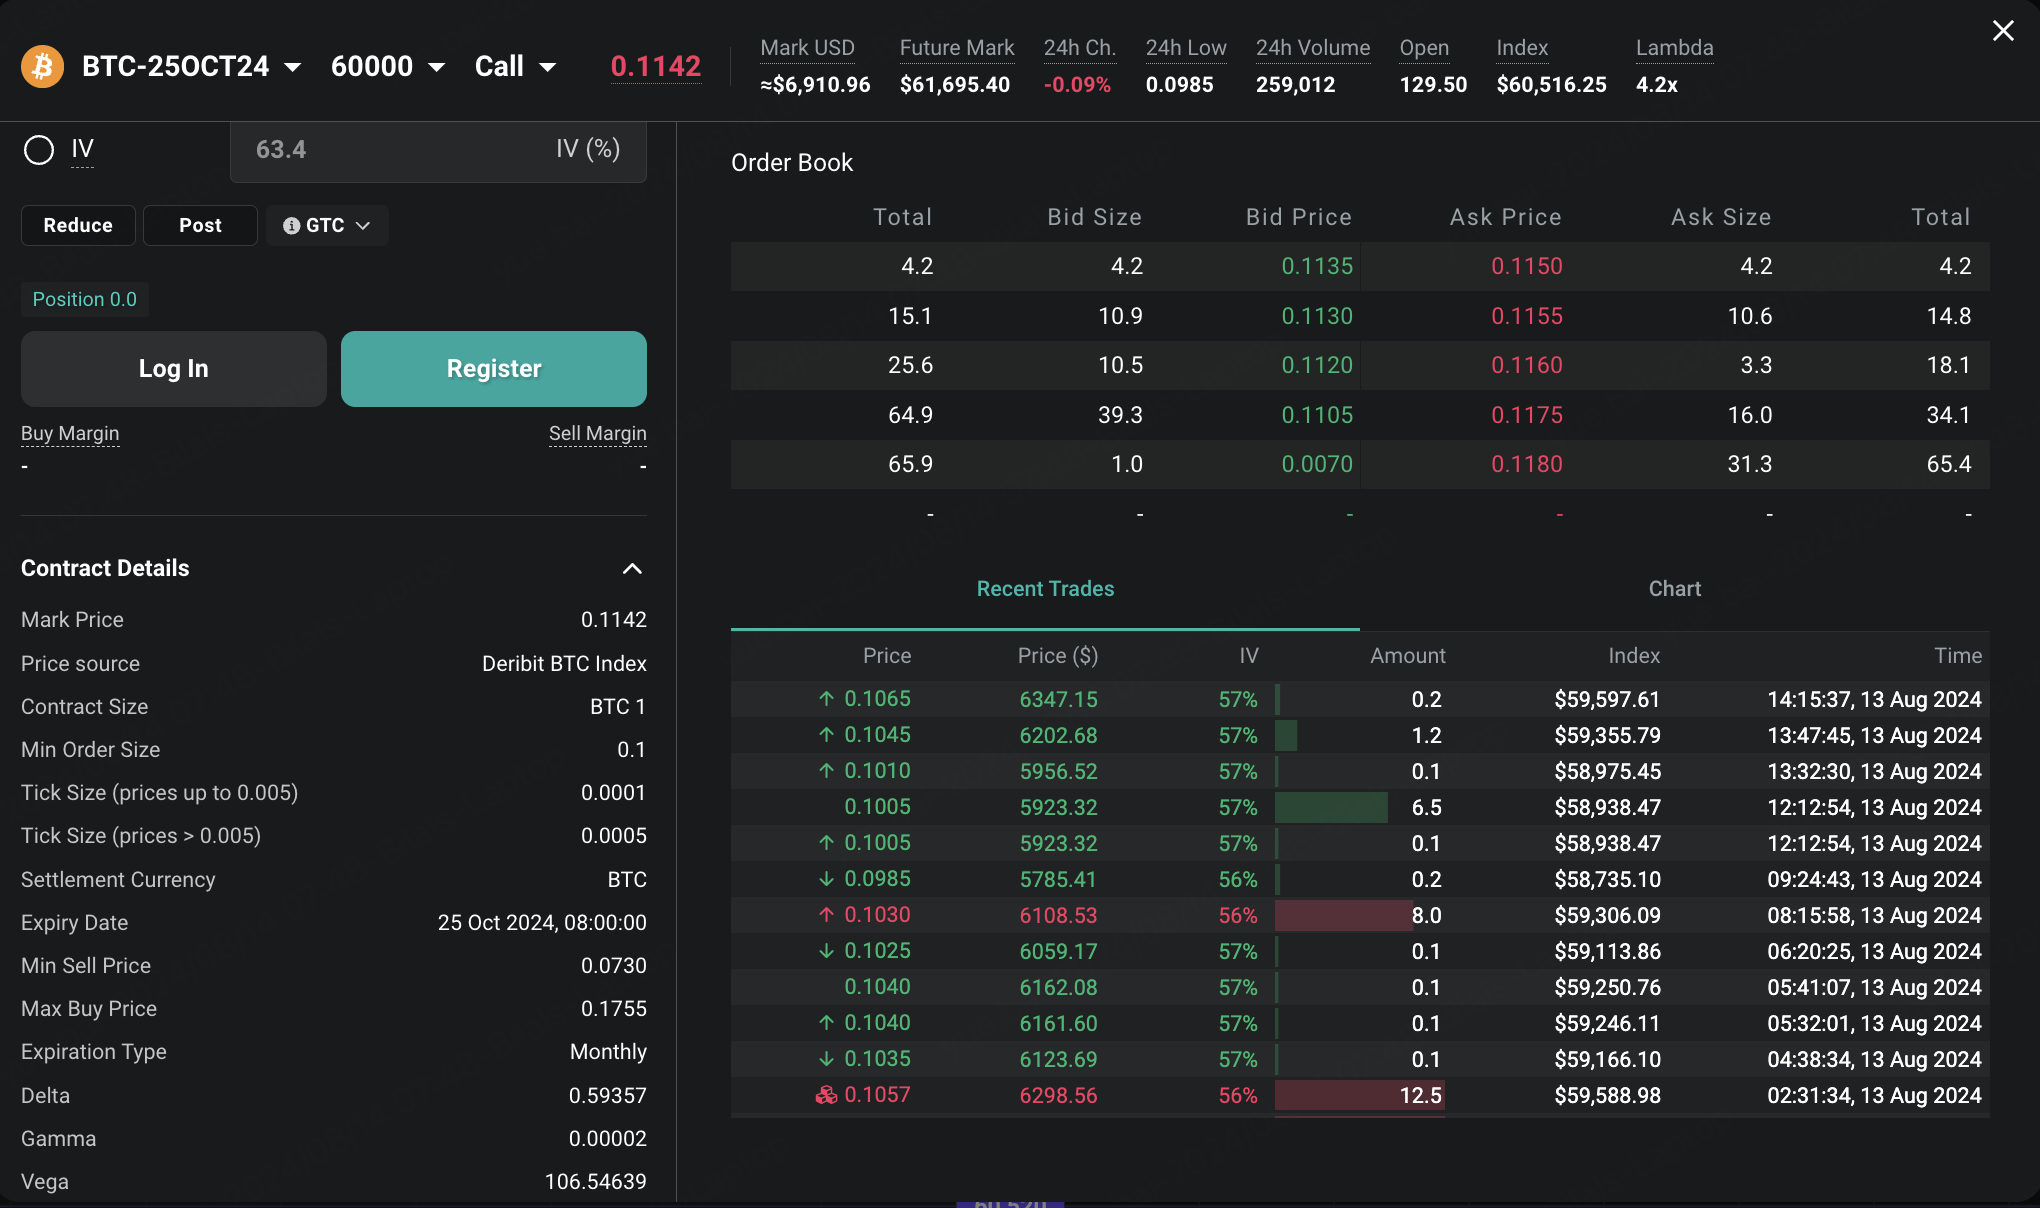

In [20]:
from portstress.core.black_scholes import BS_PARAMETERS, calc_delta,calc_vega, bs_pricing

(pd.to_datetime('25OCT24', format='%d%b%y') - pd.to_datetime('2024-08-13')).days / 365
print(calc_vega(strike=60000, time_to_expiry = 0.2, spot=61695.4, rate=0.0, vol=0.634, put_call='call', cost_of_carry_rate='default'))
print(calc_delta(strike=60000, time_to_expiry = 0.2, spot=61695.4, rate=0.0, vol=0.634, put_call='call', cost_of_carry_rate='default'))
print(bs_pricing(strike=60000, time_to_expiry = 0.2, spot=61695.4, rate=0.0, vol=0.634, put_call='call', cost_of_carry_rate='default'))


106.946262429286
0.5948518111566954
7740.2856051345625


In [17]:
df.to_csv('test.csv')

In [27]:

# # Splitting the 'instrument' column by "-"
# df[['underlying','expiry','strike','put_call']] = df['instrument'].str.split('-', expand=True)
# df['strike'] = df['strike'].astype(float)
# df['put_call'] = df['put_call'].map({'P':'put','C':'call'})
# df['underlying-expiry'] = df['underlying'] + "-" + df['expiry']
# df['expiry'] = pd.to_datetime(df['expiry'], format='%d%b%y')
# # Calculate time to expiry
# valuation_day = pd.to_datetime('2024-08-05')
# df['time_to_expiry'] = (df['expiry'] - valuation_day).dt.days / 365
# # convert expiry to a string
# df['expiry'] = df['expiry'].dt.strftime('%Y-%m-%d')


# # get market data from deribit
# deribit_res = get_order_book(instruments=df['instrument'].to_list())
# df = pd.merge(df, deribit_res,how='left',left_on='instrument',right_on='instrument_name')


# # calculate input for BSM		
# df['cost_of_carry_rate'] = 'default'
# df['multiplier'] = 1
# df['rate'] = 0.03
# df['vol'] = df['mark_iv'] / 100
# df['spot'] = df['index_price'].values[0]
# # df['position_vega'] = df['vega'] * df['quantity']

# # calculate atm_ivol
# df_atm = get_atm_ivol()
# df = pd.merge(df,df_atm,on='underlying-expiry',how='left')


1822 instruments have been crawled.


In [16]:
# df.to_csv('temp2.csv')
# df=pd.read_csv('temp2.csv')

In [14]:
df=df[['instrument','underlying','expiry','strike','put_call','multiplier',
    'quantity','time_to_expiry','rate','cost_of_carry_rate','vol','spot','atm_ivol']]

## Spot Vol Shocks

In [16]:
spot_vol_shocks = portstress.crypto.CryptoSpotVolShocks(crypto_parameters)

In [17]:
post_stress, col = spot_vol_shocks.apply_spot_vol_shocks(df)

In [31]:
portstress.core.black_scholes.bs_pricing(strike=50000, time_to_expiry=0.232877, spot=54681.59, rate=0.03, vol=0.5775, put_call='put')
portstress.core.black_scholes.calc_vega(strike=50000, time_to_expiry=0.232877, spot=54681.59, rate=0.03, vol=0.5775, put_call='put')

# np.float64(3606.873391368419)
# np.float64(3700.518323796012)

np.float64(93.56524889234046)

In [26]:
post_stress

,instrument,underlying,expiry,strike,put_call,multiplier,quantity,time_to_expiry,rate,cost_of_carry_rate,vol,spot,atm_ivol,spot_shock,vol_shock,Fear Avalanche,Bullish Frenzy,Bullish Calm,Bearish Fade,BTC Leads,ETH Leads
0,BTC-27DEC24,BTC,2024-12-27,NaN,NaN,1,-10.00,0.37,0.03,default,NaN,"61,075.02",62.95,0.01,0.10,"152,687.55","-152,687.55","-61,075.02","61,075.02","-61,075.02","-6,107.50"
1,BTC-27DEC24,BTC,2024-12-27,NaN,NaN,1,-10.00,0.37,0.03,default,NaN,"61,075.02",62.95,0.01,0.10,"152,687.55","-152,687.55","-61,075.02","61,075.02","-61,075.02","-6,107.50"
2,BTC-27DEC24,BTC,2024-12-27,NaN,NaN,1,-10.00,0.37,0.03,default,NaN,"61,075.02",62.95,0.01,0.10,"152,687.55","-152,687.55","-61,075.02","61,075.02","-61,075.02","-6,107.50"
3,BTC-27DEC24,BTC,2024-12-27,NaN,NaN,1,-10.00,0.37,0.03,default,NaN,"61,075.02",62.95,0.01,0.10,"152,687.55","-152,687.55","-61,075.02","61,075.02","-61,075.02","-6,107.50"
4,BTC-PERPETUAL,BTC,NaN,NaN,NaN,1,550.00,NaN,0.03,default,NaN,"61,075.02",NaN,0.01,0.10,"-8,397,815.25","8,397,815.25","3,359,126.10","-3,359,126.10","3,359,126.10","335,912.61"
5,BTC-PERPETUAL,BTC,NaN,NaN,NaN,1,550.00,NaN,0.03,default,NaN,"61,075.02",NaN,0.01,0.10,"-8,397,815.25","8,397,815.25","3,359,126.10","-3,359,126.10","3,359,126.10","335,912.61"
6,BTC-PERPETUAL,BTC,NaN,NaN,NaN,1,550.00,NaN,0.03,default,NaN,"61,075.02",NaN,0.01,0.10,"-8,397,815.25","8,397,815.25","3,359,126.10","-3,359,126.10","3,359,126.10","335,912.61"
7,BTC-PERPETUAL,BTC,NaN,NaN,NaN,1,550.00,NaN,0.03,default,NaN,"61,075.02",NaN,0.01,0.10,"-8,397,815.25","8,397,815.25","3,359,126.10","-3,359,126.10","3,359,126.10","335,912.61"
8,BTC-25OCT24-44000-P,BTC,2024-10-25,"44,000.00",put,1,-50.00,0.20,0.03,default,0.63,"61,075.02",57.51,0.01,0.10,"-402,284.74","12,531.45","28,556.61","-19,992.33","10,146.96","-11,739.79"
9,BTC-25OCT24-45000-P,BTC,2024-10-25,"45,000.00",put,1,-150.00,0.20,0.03,default,0.62,"61,075.02",57.51,0.01,0.10,"-1,257,531.67","46,220.52","96,208.53","-70,287.28","35,894.42","-37,240.32"


In [18]:
for k in crypto_parameters.crypto_shocks.keys():
    print(f"{k}: {int(post_stress[k].sum()):,}")


Fear Avalanche: -37,310,655
Bullish Frenzy: 31,922,788
Bullish Calm: 13,790,723
Bearish Fade: -13,460,449
BTC Leads: 13,106,674
ETH Leads: 1,046,603


## Vol Surface Shocks

In [19]:
vol_surface_shocks = portstress.crypto.CryptoVolSurfaceShocks(vol_surface_shocks_parameters)

In [23]:
df_options = df[df.put_call.isin(['put','call'])].copy()
re = vol_surface_shocks.run(df_options)
pd.DataFrame(re)

,product,measure,value,group,liquidity,type
0,BTC,Parallel,"-46,320.65",None,False,ix
1,BTC,TermStructure,"-11,509.96",None,False,ix
2,BTC,Skew,"-10,309.38",None,False,ix
3,BTC,BidAsk,"-19,250.96",None,False,ix
4,BTC,Sum,"-87,390.95",None,False,ix
5,Sum,Parallel,"-46,320.65",None,False,ix
6,Sum,TermStructure,"-11,509.96",None,False,ix
7,Sum,Skew,"-10,309.38",None,False,ix
8,Sum,Sum,"-68,139.99",None,False,ix


## Ivol Timing

In [2]:
df = pd.read_excel('ivol_timing.xlsx')
df['time'] = pd.to_datetime(df['timestamp'], unit='ms')

In [28]:
# Volatility Index

from datetime import datetime, timedelta
import requests

ccy='BTC'
end_timestamp = int(datetime.now().timestamp() * 1000)
time_24_hours_ago = datetime.now() - timedelta(hours=24)
start_timestamp = int(time_24_hours_ago.timestamp() * 1000)
url = f"https://test.deribit.com/api/v2/public/get_volatility_index_data"

r = requests.get(url, params = {'currency': ccy,
                                'end_timestamp': end_timestamp,
                                'start_timestamp': start_timestamp,
                                'resolution':3600})

df_ivol_index = pd.DataFrame(r.json()['result']['data']).rename(columns={0:'timestamp',1:'open',2:'high',3:'low',4:'close'})
df_ivol_index['time'] = pd.to_datetime(df_ivol_index['timestamp'], unit='ms')
df_ivol_index['ivol_index'] = df_ivol_index['close']


In [29]:
import plotly.graph_objects as go

# Create separate traces for buy and sell
buy_trace = go.Scatter(x=df[df['direction'] == ' buy']['time'], y=df[df['direction'] == ' buy']['iv'],
                       mode='markers', marker=dict(color='blue', size=5), name='Buy')
sell_trace = go.Scatter(x=df[df['direction'] == ' sell']['time'], y=df[df['direction'] == ' sell']['iv'],
                        mode='markers', marker=dict(color='red', size=5), name='Sell')
# Line trace for ivol data
line_trace = go.Scatter(
    x=df_ivol_index['time'],
    y=df_ivol_index['ivol_index'],
    mode='lines',
    line=dict(color='green'),
    name='Ivol Index'
)

# Create figure with both traces
fig = go.Figure([buy_trace, sell_trace,line_trace])

# Update layout
fig.update_layout(title='IV vs Time',
                  xaxis_title='Time',
                  yaxis_title='IV')

# Show plot
fig.show()